In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## Загружаем данные и готовим их к работе:

In [2]:
data = pd.read_csv('GrandMaster_Ranked_Games.csv')

In [3]:
data

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4241678498,2098,0,0,0,1,1,0,1,1,...,72,125866,70528,832,84,16.8,205,9,65312,88202
1,4233222221,1686,0,0,1,0,0,0,0,0,...,59,78424,58032,640,73,14.6,214,5,31415,61040
2,4233113995,1588,1,1,1,1,0,1,2,1,...,30,62134,47408,608,63,12.6,133,5,27846,32107
3,4229230455,1126,1,0,1,0,1,0,1,0,...,13,32999,32064,461,53,10.6,92,3,23511,10775
4,4228244819,1262,1,0,0,0,1,1,3,0,...,5,35272,35372,506,54,10.8,113,2,17891,24158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65891,3868504952,1928,0,1,0,0,0,0,2,0,...,60,94554,72361,804,80,16.0,209,10,57739,72450
65892,4110201724,1837,1,1,0,0,1,0,3,0,...,29,88366,52625,660,70,14.0,168,5,25003,45455
65893,4100240254,948,1,1,1,0,0,0,1,0,...,3,16574,20972,351,40,8.0,56,0,7138,6808
65894,4216107910,2479,1,1,0,0,0,0,3,1,...,41,149798,72167,789,86,17.2,258,6,34890,62124


In [4]:
data = data.loc[:,data.columns != 'gameId']

In [5]:
binary_column = [c for c in data.columns if data[c].unique().shape == (2,)]
numeric_column = [c for c in data.columns if data[c].unique().shape != (2,)]

In [6]:
temp = data['blueWins'] > 2
for c in numeric_column:
    temp = temp | (data[c] < data[c].quantile(0.005)) | (data[c] > data[c].quantile(0.995))
rows_to_drop = data[temp].index
work_data = data.drop(rows_to_drop)

In [7]:
work_data_b = work_data.loc[:,binary_column]
work_data_n = work_data.loc[:,numeric_column]
stand = (work_data_n - work_data_n.mean(axis = 0))/work_data_n.std(axis = 0)

In [8]:
data_stand = pd.concat((stand, work_data_b), axis = 1)

## Обучающая и тестовая выборки

In [9]:
X = data_stand.drop(['blueWins','redWins'], axis=1)
y = work_data['blueWins']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(46075, 15359)

## Обучаем классификатор

In [11]:
from sklearn.neural_network import MLPClassifier

In [13]:
mlp_model = MLPClassifier(hidden_layer_sizes = (4,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)

In [14]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 2.13 s


MLPClassifier(activation='logistic', hidden_layer_sizes=(4,), random_state=42,
              solver='lbfgs')

In [15]:
No = 42
if (y_test[No] == 0):
    print("Синяя команда проиграла")
else:
    print("Синяя команда выиграла")

predict = mlp_model.predict([X_test.loc[No,:]])[0]
if (predict == 0):
    print("Предсказание проигрыш")
else:
    print("Предсказание победа")

Синяя команда проиграла
Предсказание проигрыш


In [16]:
No = 26454
if (y_test[No] == 0):
    print("Синяя команда проиграла")
else:
    print("Синяя команда выиграла")

predict = mlp_model.predict([X_test.loc[No,:]])[0]
if (predict == 0):
    print("Предсказание проигрыш")
else:
    print("Предсказание победа")

Синяя команда проиграла
Предсказание проигрыш


## Проверяем качество классификатора

In [17]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

#### Ошибки на обучающей и тестовой выборках:

In [18]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.0031253391209983723 0.006445732144019793


In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_train, y_train_pred)

0.9968746608790017

In [21]:
accuracy_score(y_test, y_test_pred)

0.9935542678559802

#### Подбор _гипер_параметров

In [76]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

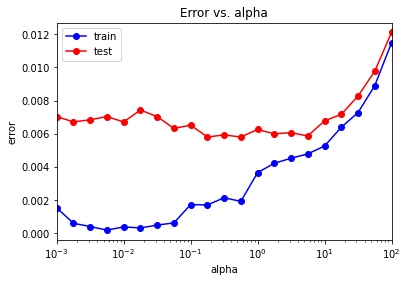

In [77]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

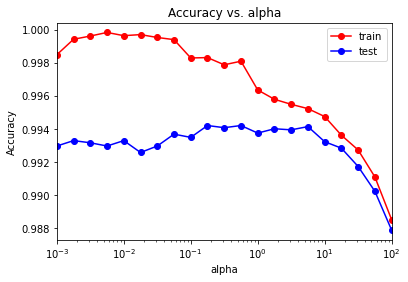

In [78]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки:

In [79]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.00017362995116657623 0.005794648089068299


Оптимальное значение alpha:

In [80]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.17782794 0.56234133]


In [81]:
alpha_opt = alpha_opt[0]

### Классификатор при найденном оптимальном значении alpha:

In [82]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.0016928920238741183
0.005794648089068299


### Зависимость ошибки от числа нейронов

In [22]:
test_err = []
train_err = []
train_acc = []
test_acc = []

for k in range(3,50):
    mlp_model = MLPClassifier(hidden_layer_sizes = (k,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

In [42]:
number = np.arange(3,50)

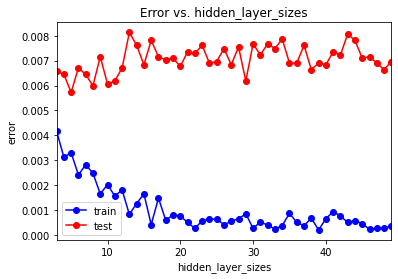

In [41]:
plt.plot(number, train_err, 'b-o', label = 'train')
plt.plot(number, test_err, 'r-o', label = 'test')
plt.xlim([np.min(number), np.max(number)])
plt.title('Error vs. hidden_layer_sizes')
plt.xlabel('hidden_layer_sizes')
plt.ylabel('error')
plt.legend()

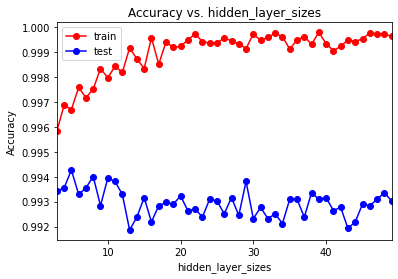

In [40]:
plt.plot(number, train_acc, 'r-o', label = 'train')
plt.plot(number, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(number), np.max(number)])
plt.title('Accuracy vs. hidden_layer_sizes')
plt.xlabel('hidden_layer_sizes')
plt.ylabel('Accuracy')
plt.legend()

### Матрица рассогласования:

In [43]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[7860   47]
 [  60 7392]]


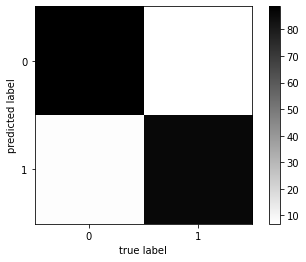

In [45]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

### Другие метрики качества:

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7920
           1       0.99      0.99      0.99      7439

    accuracy                           0.99     15359
   macro avg       0.99      0.99      0.99     15359
weighted avg       0.99      0.99      0.99     15359

